In [3]:
from scipy.stats import norm
import numpy as np
from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt

eps = 1
def simulate(T, eps = 1, N_bootstrap = 10000, N = 3, plus_last_xi=False, 
             sigma=1, init_x=None, return_history=False, verbose=False):
    if verbose:
        print('Generating r.v. for Monte Carlo')
    
    xi = np.array([])
    if type(sigma) != np.ndarray and type(sigma) != list:
        xi = norm.rvs(scale=sigma, size=(N_bootstrap, N, T))
    else:
        assert len(sigma) == N
        xi = np.zeros(shape=(N_bootstrap, N, T))
        for i in range(N):
            xi[:, i, :] = norm.rvs(scale=sigma[i], size=(N_bootstrap, T))
    
    if init_x is None:
        init_x = np.zeros(shape=(N_bootstrap, N))
    else:
        init_x = np.ones(shape=(N_bootstrap, N)) * np.array(init_x)[None, :]
    
    x = init_x.copy()
    pairs = np.broadcast_arrays(np.arange(N)[:, None], np.arange(N)[None, :])
    history = np.zeros(shape=(N_bootstrap, N, T))
    history[:, :, 0] = x.copy()
    
    range_T = range(T)
    if verbose:
        print('Simulating')
        range_T = tqdm(range_T)
    for t in range_T:
        dists_indicators = np.abs(x[:, pairs[0]] - x[:, pairs[1]]) <= eps
        x = (x[:, :, None] * dists_indicators).sum(axis=1) / dists_indicators.sum(axis=1)
        history[:, :, t] = x.copy()
        if t < T - 1 or plus_last_xi:
            x += xi[:, :, t]
            if plus_last_xi:
                history[:, :, t] = x.copy()
    
    if return_history:
        return history
    
    return x

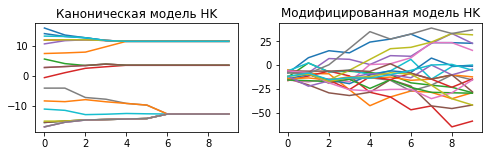

In [13]:
import matplotlib.pyplot as plt 

N_particles = 40
out_canon = simulate(100, N=N_particles, sigma=0, N_bootstrap=1, eps=5,
               init_x=np.random.randint(0,40,N_particles)-20, return_history=True).squeeze()
 
N_particles = 20
out_modified = simulate(100, N=N_particles, sigma=8, N_bootstrap=1, eps=4,
               init_x=np.random.randint(0,20,N_particles)-20, return_history=True).squeeze()

plt.figure(figsize=(8,2))
plt.subplot(1,2,1)
plt.title('Каноническая модель HK')
for i in range(N_particles):
    plt.plot(out_canon[i][:10])

plt.subplot(1,2,2)
plt.title('Модифицированная модель HK')
for i in range(N_particles):
    plt.plot(out_modified[i][:10])
plt.show()

In [15]:
import numpy as np
def ConstructMatrix(vector, normalize_lines=True):
    result = np.ones((3,3))
    result[0, 1] = result[1, 0] = vector[0]
    result[0, 2] = result[2, 0] = vector[1]
    result[1, 2] = result[2, 1] = vector[2]
    
    if normalize_lines:
        result = result / result.sum(axis=1, keepdims=True)
    
    return result

import itertools

def GetIds(N=3):
    id_to_matrix = []
    for vector in itertools.product([0, 1], repeat=N):
        id_to_matrix.append(np.array(ConstructMatrix(vector, False), dtype=int))
    return np.array(id_to_matrix)

def GetBiMeasures(T, N_bootstrap, sigmas, verbose=False):
    history = simulate(T, N_bootstrap=N_bootstrap, sigma=sigmas, 
                       return_history=True, plus_last_xi=True, verbose=verbose)
    
    if verbose:
        print('Calculating distance matrix history...')
    T, N, n_samples = history.shape
    pairs = np.broadcast_arrays(np.arange(N)[:, None], np.arange(N)[None, :])
    dist_matrix_history = (np.abs(history[:, pairs[0], :] - history[:, pairs[1], :]) <= eps) * 1
    dist_matrix_history = np.moveaxis(dist_matrix_history, 3, 1)

    if verbose:
        print('Calculating means...')

    matrixes = GetIds(N)
    tmp = np.abs(dist_matrix_history[:, :, None, ...] - matrixes[None, None,...])
    means = (tmp.reshape(list(tmp.shape[:-2]) + [-1]).sum(axis=-1) == 0).mean(axis=0)
    
    return means

def GetMatrixEquation(matrix):
    lines = str(matrix).split('\n ')
    for i, line in enumerate(lines):
        lines[i] = line.replace("[", "").replace("]", "").replace(" ", " & ") + ' \\\\'
    eq = r'\begin{eqnarray*}' + \
         lines[0] + \
         lines[1] + \
         lines[2] + \
         r'\end{eqnarray*}'
    
    return eq

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

def GetFigure(measures, title=""):
    plt.figure(figsize=(18, 8))
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.title(title) 
        plt.plot(measures[:, i])
        plt.yticks([0, 0.2, 0.4,0.6, 0.8 , 1])
        plt.text(0.7, 0.55, GetMatrixEquation(GetIds()[i]), 
                 {'color': 'black', 'fontsize': 14}, transform=ax.transAxes)
    plt.show()

In [16]:
sigma_05 = GetBiMeasures(3000, 10000, [0.5, 0.5, 2], verbose=True)

Generating r.v. for Monte Carlo


  1%|          | 17/3000 [00:00<00:17, 168.00it/s]

Simulating


100%|██████████| 3000/3000 [00:21<00:00, 142.03it/s]


Calculating distance matrix history...
Calculating means...


In [22]:
plt.style.use('seaborn')

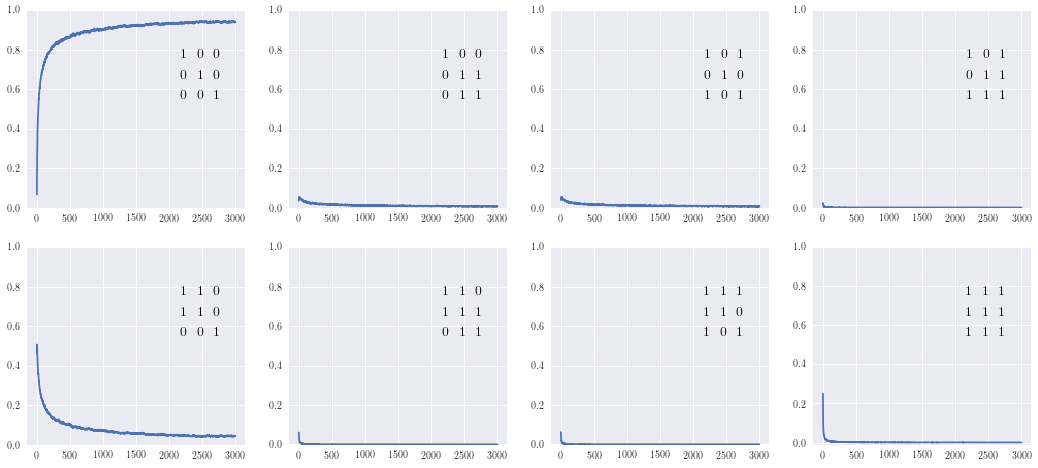

In [23]:
GetFigure(sigma_05)

In [18]:
sigma_025 = GetBiMeasures(3000, 10000, [0.25, 0.25, 2], verbose=True)

Generating r.v. for Monte Carlo


  1%|          | 21/3000 [00:00<00:14, 208.94it/s]

Simulating


100%|██████████| 3000/3000 [00:15<00:00, 197.30it/s]


Calculating distance matrix history...
Calculating means...


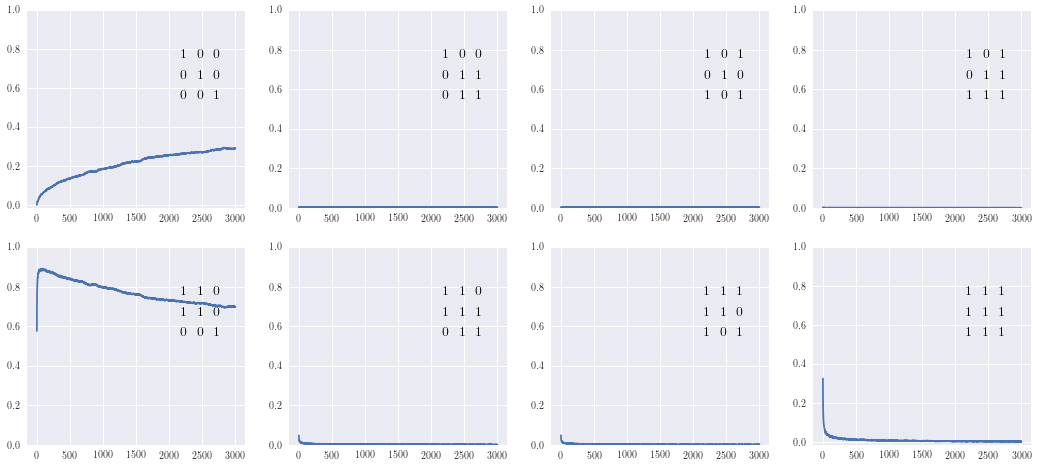

In [24]:
GetFigure(sigma_025)

In [20]:
sigma_021 = GetBiMeasures(3000, 10000, [0.21, 0.21, 2], verbose=True)

Generating r.v. for Monte Carlo


  1%|          | 20/3000 [00:00<00:15, 191.85it/s]

Simulating


100%|██████████| 3000/3000 [00:16<00:00, 182.65it/s]


Calculating distance matrix history...
Calculating means...


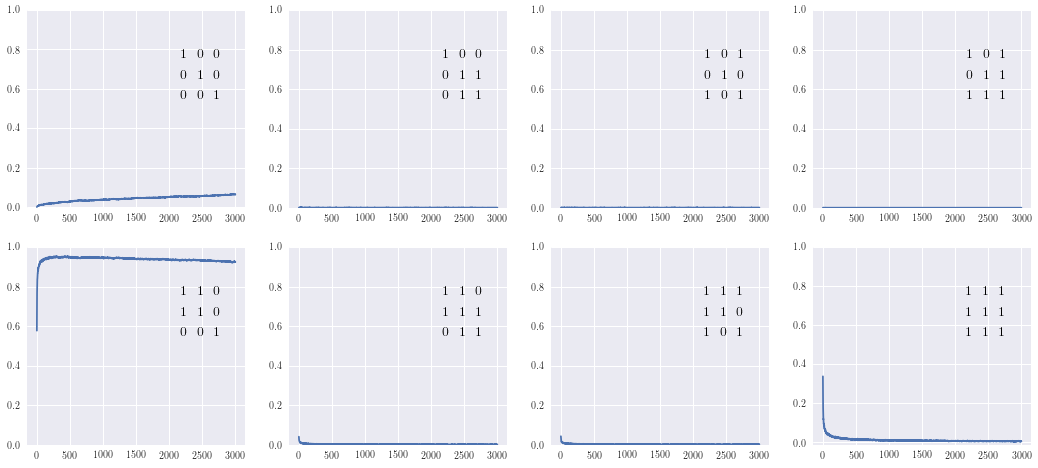

In [25]:
GetFigure(sigma_021)

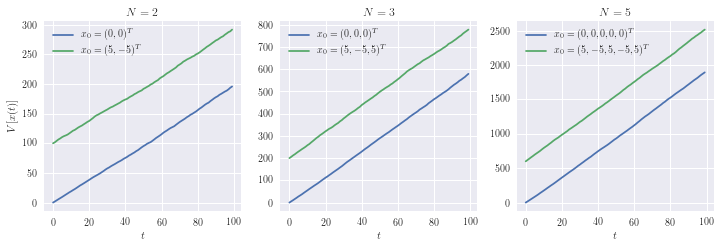

In [26]:
plt.style.use('seaborn')
plt.figure(figsize=(12,3.5))

T_max=100 
N_bootstrap=10000


labels = ['$x_0 = (0, 0)^T$', '$x_0 = (5,-5)^T$']
T_max=100 
N_bootstrap=10000
sigmas = [1,1]
plt.subplot(1,3,1)
for i, init_x in enumerate([[0, 0], [5,-5]]):
    history = simulate(T_max, return_history=True, N=2, N_bootstrap=N_bootstrap, sigma=sigmas, init_x=init_x)
    x = np.linspace(-5, 5, 1000)
    statistic = (history[:, 0, :] - history[:, 1, :]) ** 2 
    plot_y = statistic.mean(axis=0)
    

    plt.grid(color='w')
    plt.xlabel('$t$')
    plt.ylabel('$V[x(t)]$')
    plt.title('$N = 2$')
    plt.plot(plot_y, label=labels[i])
plt.legend()    

labels = ['$x_0 = (0, 0, 0)^T$', '$x_0 = (5,-5,5)^T$']
sigmas = [1,1,1]
plt.subplot(1,3,2)
for i, init_x in enumerate([[0, 0, 0], [5,-5, 5]]):
    history = simulate(T_max, return_history=True, N_bootstrap=N_bootstrap, sigma=sigmas, init_x=init_x)
    x = np.linspace(-5, 5, 1000)
    statistic = (history[:, 0, :] - history[:, 1, :]) ** 2 +\
                (history[:, 1, :] - history[:, 2, :]) ** 2 +\
                (history[:, 0, :] - history[:, 2, :]) ** 2
    plot_y = statistic.mean(axis=0)

    plt.grid(color='w')
    plt.xlabel('$t$')
    plt.title('$N = 3$')
    plt.plot(plot_y, label=labels[i])
plt.legend()   

labels = ['$x_0 = (0, 0, 0, 0, 0)^T$', '$x_0 = (5,-5,5,-5,5)^T$']
sigmas = [1,1,1,1,1]
plt.subplot(1,3,3)
for i, init_x in enumerate([[0, 0, 0, 0, 0], [5,-5, 5, -5, 5]]):
    history = simulate(T_max, return_history=True, N=5, N_bootstrap=N_bootstrap, sigma=sigmas, init_x=init_x)
    x = np.linspace(-5, 5, 1000)
    statistic = (history[:, 0, :] - history[:, 1, :]) ** 2 +\
                (history[:, 1, :] - history[:, 2, :]) ** 2 +\
                (history[:, 0, :] - history[:, 2, :]) ** 2 +\
                (history[:, 3, :] - history[:, 4, :]) ** 2 +\
                (history[:, 4, :] - history[:, 2, :]) ** 2 +\
                (history[:, 4, :] - history[:, 1, :]) ** 2 +\
                (history[:, 4, :] - history[:, 0, :]) ** 2 +\
                (history[:, 3, :] - history[:, 0, :]) ** 2 +\
                (history[:, 3, :] - history[:, 1, :]) ** 2 +\
                (history[:, 3, :] - history[:, 2, :]) ** 2
    plot_y = statistic.mean(axis=0)

    plt.grid(color='w')
    plt.xlabel('$t$')
    plt.title('$N = 5$')
    plt.plot(plot_y, label=labels[i])

plt.legend()
plt.show()